<a href="https://colab.research.google.com/github/PhuongNhi187/TieuLuan_NguyenThiPhuongNhi_2024_2025/blob/main/training_data_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SENTIMENT ANALYSIS **

In [ ]:
print("Phiên bản Numpy hiện tại:", np.__version__)
print("Phiên bản Pandas hiện tại:", pd.__version__)
print("Phiên bản TensorFlow hiện tại:", tf.__version__)
print("Phiên bản Gensim hiện tại:", gensim.__version__)
print("Phiên bản sklearn hiện tại:", sklearn.__version__)
print("Phiên bản matplotlib hiện tại:", matplotlib.__version__)
print("Phiên bản requests hiện tại:", requests.__version__)
print("Phiên bản joblib hiện tại:", joblib.__version__)

Phiên bản Numpy hiện tại: 1.25.2
Phiên bản Pandas hiện tại: 2.0.3
Phiên bản TensorFlow hiện tại: 2.15.0
Phiên bản Gensim hiện tại: 4.3.2
Phiên bản sklearn hiện tại: 1.2.2
Phiên bản matplotlib hiện tại: 3.7.1
Phiên bản requests hiện tại: 2.31.0
Phiên bản joblib hiện tại: 1.4.2


#Chuẩn bị data

In [2]:
!pip install gensim

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Tieu_luan/data/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Tieu_luan/data


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GlobalAveragePooling1D, Dropout, Input, BatchNormalization, Reshape, Layer
from tensorflow.keras.models import Sequential
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.utils import plot_model
import joblib
from sklearn import metrics as m


In [5]:
# Function tính accuracy, precision, recall, f1-score
def calculate_results(y_true, y_pred):

  model_accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [6]:
df = pd.read_csv("data_preprocessed.csv")

In [7]:
df = df [['preprocess', 'target']]

In [8]:
print(df.shape)

num = df['target'].value_counts()
num

(689379, 2)


target
1    394219
0    295160
Name: count, dtype: int64

In [9]:
x = df['preprocess']
y = df['target']

x_train, x_temp, y_train, y_temp = train_test_split(x, y, train_size=0.8, random_state=42)
x_val, x_test, y_val, y_test= train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
len(x_train), len(x_val), len(x_test)

(551503, 68938, 68938)

In [10]:
x_train_list = x_train.tolist()
x_val_list = x_val.tolist()
x_test_list = x_test.tolist()

<Axes: >

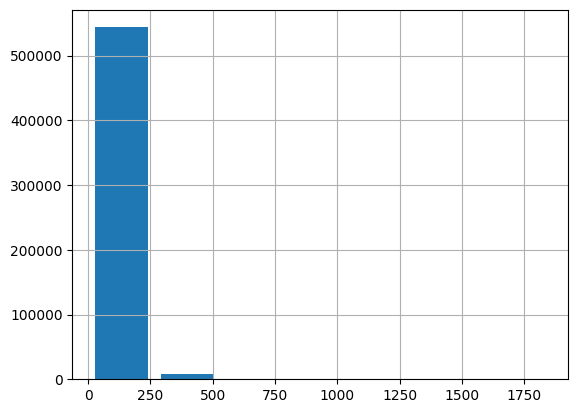

In [11]:
a = [str(x) for x in x_train_list]
lens = [len(i) for i in a]
pd.Series(lens).hist(bins=7, rwidth=0.8)

In [12]:
# tìm từ có len gần bằng 95% char_lens
output_len = int(np.percentile(lens, 95))
output_len

171

In [13]:
words = []

for word in df['preprocess']:
    words.append(word)
# giới hạn tối đa của câu
max_tokens = len(set(words))
max_tokens

615656

In [14]:
# tạo số cột tương ứng với số lượng thuộc tính của y => 2 cột y được tạo
y_train_one_hot = tf.one_hot(y_train.to_numpy(), depth=len(set(y)))
y_val_one_hot = tf.one_hot(y_val.to_numpy(), depth=len(set(y)))
y_test_one_hot = tf.one_hot(y_test.to_numpy(), depth=len(set(y)))

y_train_one_hot

<tf.Tensor: shape=(551503, 2), dtype=float32, numpy=
array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)>

#Khởi tạo TextVectorization

In [15]:
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    standardize="lower",
                                    split="whitespace",
                                    output_sequence_length=output_len)

In [ ]:
text_vectorizer.adapt(x_train_list)

In [ ]:
vocab = text_vectorizer.get_vocabulary()
len(vocab)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_list, y_train_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((x_val_list, y_val_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_list, y_test_one_hot))

train_dataset

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

In [ ]:
token_embedding = Embedding(input_dim = len(vocab),
                           output_dim = output_len,
                           mask_zero=True,
                           name="token_embedding")

#TextVectorization cho ML

In [42]:
# x = df['preprocess']
# y = df['target']

# x_train, x_temp, y_train, y_temp = train_test_split(x, y, train_size=0.8, random_state=42)
# len(x_train), len(x_temp)

In [43]:
x_train_list_ml = x_train.tolist()
x_test_list_ml = x_temp.tolist()

In [44]:
x_train_vectors = text_vectorizer(x_train_list_ml).numpy()
x_test_vectors = text_vectorizer(x_test_list_ml).numpy()

#BI-LSTM TextVectorization

In [57]:
activation_function = 'tanh'

inputs = Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embedding(text_vectors)

x = Bidirectional(LSTM(256, return_sequences=True))(token_embeddings)
x = GlobalAveragePooling1D()(x)
x = Dense(units=500, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=200, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=100, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=50, activation=activation_function)(x)
outputs = Dense(len(set(df['target'])), activation="sigmoid")(x)

model_bilstm = tf.keras.Model(inputs, outputs)


model_bilstm.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_bilstm.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 171)               0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 171, 171)          10191771  
 )                                                               
                                                                 
 bidirectional_1 (Bidirecti  (None, 171, 512)          876544    
 onal)                                                           
                                                                 
 global_average_pooling1d_1  (None, 512)               0         
  (GlobalAveragePooling1D)                                 

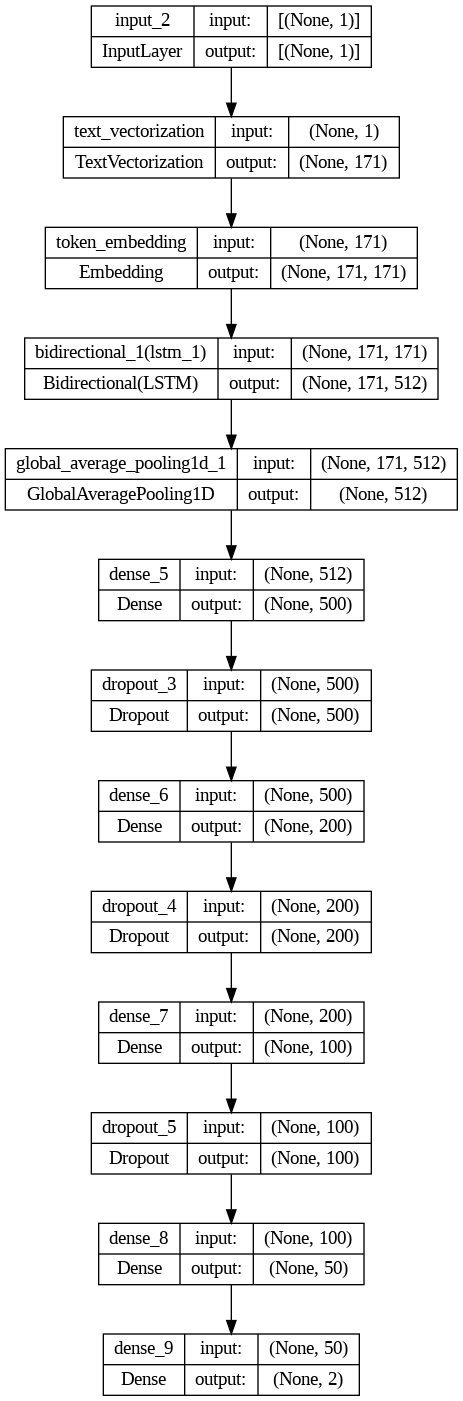

In [58]:
plot_model(model_bilstm, to_file='model_BiLSTM.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model_bilstm.fit(train_dataset,
                           epochs=100,
                           validation_data= valid_dataset,
                           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])

model_bilstm.evaluate(valid_dataset)

In [ ]:
loss, accuracy = model_bilstm.evaluate(model_bilstm, y_val_one_hot)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

In [ ]:
model_bilstm_pred_probs = model_bilstm.predict(test_dataset)

model_bilstm_preds = tf.argmax(model_bilstm_pred_probs, axis=1)

model_bilstm_results = calculate_results(y_true=y_test,
                                    y_pred=model_bilstm_preds)
model_bilstm_results

In [ ]:
confusion_matrix_bilstm = m.ConfusionMatrixDisplay.from_predictions(y_test, model_bilstm_preds)
confusion_matrix_bilstm

In [ ]:
joblib.dump(model_bilstm, '/content/gdrive/MyDrive/Tieu_luan/model_BiLSTM_TextVectorization.pkl')

phía trên history là test

In [59]:
history = model_bilstm.fit(train_dataset,
                           epochs=100,
                           validation_data= valid_dataset,
                           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])

model_bilstm.evaluate(valid_dataset)

Epoch 1/100
17235/17235 [==============================] - 428s 24ms/step - loss: 0.3458 - accuracy: 0.8578 - val_loss: 0.3262 - val_accuracy: 0.8685
Epoch 2/100
17235/17235 [==============================] - 360s 21ms/step - loss: 0.3089 - accuracy: 0.8772 - val_loss: 0.3236 - val_accuracy: 0.8704
Epoch 3/100
17235/17235 [==============================] - 366s 21ms/step - loss: 0.2930 - accuracy: 0.8858 - val_loss: 0.3334 - val_accuracy: 0.8650
Epoch 4/100
17235/17235 [==============================] - 361s 21ms/step - loss: 0.2830 - accuracy: 0.8919 - val_loss: 0.3359 - val_accuracy: 0.8648
Epoch 5/100
17235/17235 [==============================] - 362s 21ms/step - loss: 0.2753 - accuracy: 0.8964 - val_loss: 0.3377 - val_accuracy: 0.8637
Epoch 6/100
17235/17235 [==============================] - 351s 20ms/step - loss: 0.2693 - accuracy: 0.8994 - val_loss: 0.3463 - val_accuracy: 0.8625
Epoch 7/100
2155/2155 [==============================] - 15s 7ms/step - loss: 0.3488 - accuracy: 0.8

[0.34881141781806946, 0.862659215927124]

In [64]:
joblib.dump(model_bilstm, '/content/gdrive/MyDrive/Tieu_luan/model_BiLSTM_TextVectorization.pkl')

['/content/gdrive/MyDrive/Tieu_luan/model_BiLSTM_TextVectorization.pkl']

In [82]:
# !mkdir -p saved_model

# model_bilstm.save('/content/gdrive/MyDrive/Tieu_luan/saved_model/my_model')
# !ls saved_model

# !ls saved_model/my_model

In [65]:
model_bilstm_pred_probs = model_bilstm.predict(test_dataset)

model_bilstm_preds = tf.argmax(model_bilstm_pred_probs, axis=1)

model_bilstm_results = calculate_results(y_true=y_test,
                                    y_pred=model_bilstm_preds)
model_bilstm_results

2155/2155 [==============================] - 17s 6ms/step


{'accuracy': 0.8613391743305578,
 'precision': 0.8617983553653562,
 'recall': 0.8613391743305578,
 'f1': 0.8615009111818274}

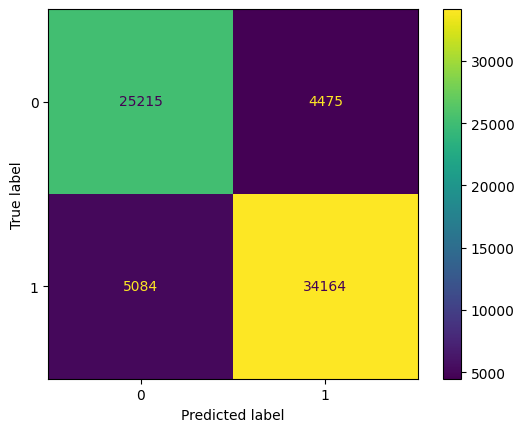

In [66]:
confusion_matrix_bilstm = m.ConfusionMatrixDisplay.from_predictions(y_test, model_bilstm_preds)
confusion_matrix_bilstm

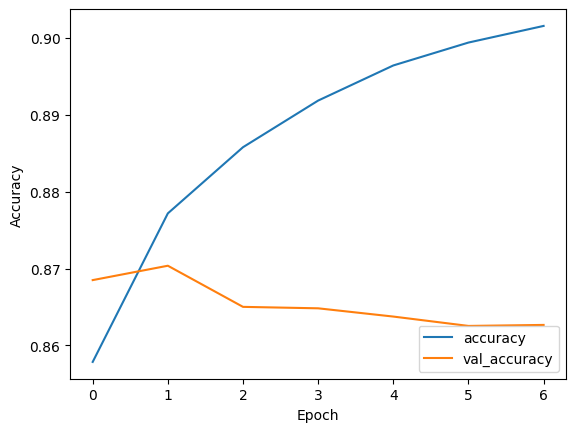

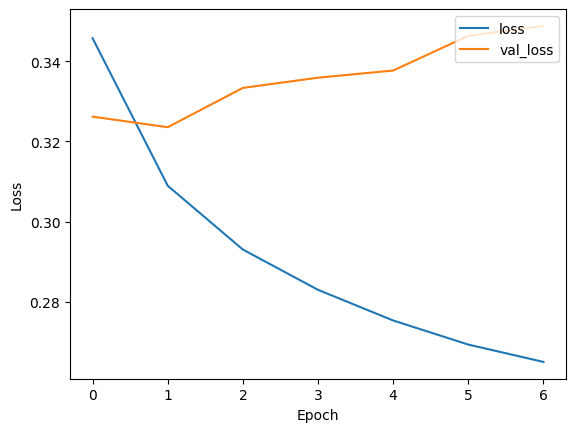

In [67]:
# Biểu đồ độ chính xác
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Biểu đồ hàm mất mát
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


#Naive Bayes TextVectorization

In [45]:
bayes_textvector = MultinomialNB()
param_dist = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'fit_prior': [True, False]
}

# Khởi tạo RandomizedSearchCV
random_search_bayes_textvector = RandomizedSearchCV(estimator=bayes_textvector, param_distributions=param_dist,
                                                    n_iter=10, cv=5, n_jobs=-1, scoring='accuracy', random_state=42)

In [46]:
random_search_bayes_textvector.fit(x_train_vectors, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
                   param_distributions={'alpha': [0.01, 0.1, 1, 10, 100],
                                        'fit_prior': [True, False]},
                   random_state=42, scoring='accuracy')

In [47]:
print("Best parameters: ", random_search_bayes_textvector.best_params_)
print("Best accuracy: ", random_search_bayes_textvector.best_score_)

Best parameters:  {'fit_prior': True, 'alpha': 0.01}
Best accuracy:  0.6304263050477642


In [48]:
print("All Results:")
for i in range(len(random_search_bayes_textvector.cv_results_['params'])):
    params = random_search_bayes_textvector.cv_results_['params'][i]
    mean_score = random_search_bayes_textvector.cv_results_['mean_test_score'][i]
    mean_fit_time = random_search_bayes_textvector.cv_results_['mean_fit_time'][i]
    std_fit_time = random_search_bayes_textvector.cv_results_['std_fit_time'][i]
    print(f"{params} --> Accuracy: {mean_score:.4f}, ")
    print(f"Fit Time: {mean_fit_time:.4f} ± {std_fit_time:.4f} seconds")

All Results:
{'fit_prior': True, 'alpha': 0.01} --> Accuracy: 0.6304, 
Fit Time: 3.6940 ± 0.0994 seconds
{'fit_prior': False, 'alpha': 0.01} --> Accuracy: 0.6304, 
Fit Time: 4.5453 ± 0.8238 seconds
{'fit_prior': True, 'alpha': 0.1} --> Accuracy: 0.6304, 
Fit Time: 4.3525 ± 0.4905 seconds
{'fit_prior': False, 'alpha': 0.1} --> Accuracy: 0.6304, 
Fit Time: 4.3614 ± 0.2844 seconds
{'fit_prior': True, 'alpha': 1} --> Accuracy: 0.6304, 
Fit Time: 3.7516 ± 0.2373 seconds
{'fit_prior': False, 'alpha': 1} --> Accuracy: 0.6304, 
Fit Time: 4.1721 ± 0.5077 seconds
{'fit_prior': True, 'alpha': 10} --> Accuracy: 0.6304, 
Fit Time: 3.9176 ± 0.3981 seconds
{'fit_prior': False, 'alpha': 10} --> Accuracy: 0.6304, 
Fit Time: 3.8461 ± 0.2773 seconds
{'fit_prior': True, 'alpha': 100} --> Accuracy: 0.6304, 
Fit Time: 3.9207 ± 0.3105 seconds
{'fit_prior': False, 'alpha': 100} --> Accuracy: 0.6304, 
Fit Time: 4.1750 ± 0.4172 seconds


In [49]:
bayes_textvector_predict = random_search_bayes_textvector.predict(x_test_vectors)

bayes_textvector_results = calculate_results(y_true=y_temp,
                                     y_pred=bayes_textvector_predict)
bayes_textvector_results

{'accuracy': 0.6287751312773797,
 'precision': 0.6277434954246709,
 'recall': 0.6287751312773797,
 'f1': 0.6017449880653339}

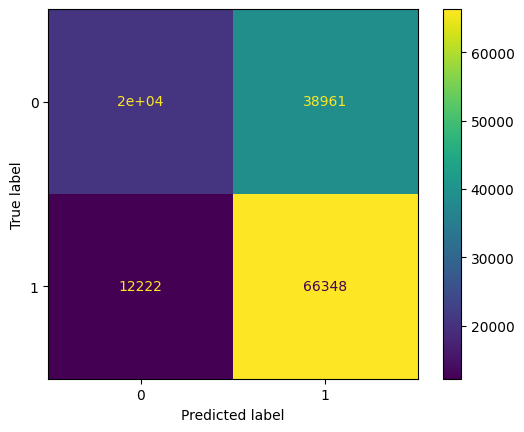

In [50]:
confusion_matrix_bayes_textvector = m.ConfusionMatrixDisplay.from_predictions(y_temp, bayes_textvector_predict)
confusion_matrix_bayes_textvector

#Decision Tree TextVectorization

In [51]:
dt_textvector = DecisionTreeClassifier()

param_grid = {
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

random_search_dt_textvector = RandomizedSearchCV(estimator=dt_textvector, param_distributions=param_grid,
                                      n_iter=50, cv=5, n_jobs=-1, scoring='accuracy', random_state=42)

In [52]:
random_search_dt_textvector.fit(x_train_vectors, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, scoring='accuracy')

In [53]:
print("Best parameters: ", random_search_dt_textvector.best_params_)
print("Best accuracy: ", random_search_dt_textvector.best_score_)

Best parameters:  {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'entropy'}
Best accuracy:  0.7198328833037542


In [54]:
print("All Results:")
for i in range(len(random_search_dt_textvector.cv_results_['params'])):
    params = random_search_dt_textvector.cv_results_['params'][i]
    mean_score = random_search_dt_textvector.cv_results_['mean_test_score'][i]
    mean_fit_time = random_search_dt_textvector.cv_results_['mean_fit_time'][i]
    std_fit_time = random_search_dt_textvector.cv_results_['std_fit_time'][i]
    print(f"{params} --> Accuracy: {mean_score:.4f}, ")
    print(f"Fit Time: {mean_fit_time:.4f} ± {std_fit_time:.4f} seconds")

All Results:
{'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 30, 'criterion': 'entropy'} --> Accuracy: 0.7094, 
Fit Time: 23.6366 ± 0.4203 seconds
{'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'gini'} --> Accuracy: 0.7173, 
Fit Time: 17.9538 ± 0.6883 seconds
{'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'gini'} --> Accuracy: 0.7019, 
Fit Time: 12.4365 ± 1.4877 seconds
{'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 40, 'criterion': 'entropy'} --> Accuracy: 0.7031, 
Fit Time: 25.4745 ± 1.6135 seconds
{'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10, 'criterion': 'entropy'} --> Accuracy: 0.7007, 
Fit Time: 12.3593 ± 1.0095 seconds
{'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'criterion': 'entropy'} --> Accuracy: 0.7188, 
Fit Time: 19.7402 ± 0.5556 seconds
{'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 40, 'criterion': 'gini'} --> Accuracy: 0.6962, 

In [55]:
dt_textvector_predict = random_search_dt_textvector.predict(x_test_vectors)

dt_textvector_results = calculate_results(y_true=y_temp,
                                     y_pred=dt_textvector_predict)
dt_textvector_results

{'accuracy': 0.7157953523455859,
 'precision': 0.7159031233414541,
 'recall': 0.7157953523455859,
 'f1': 0.7158480000364424}

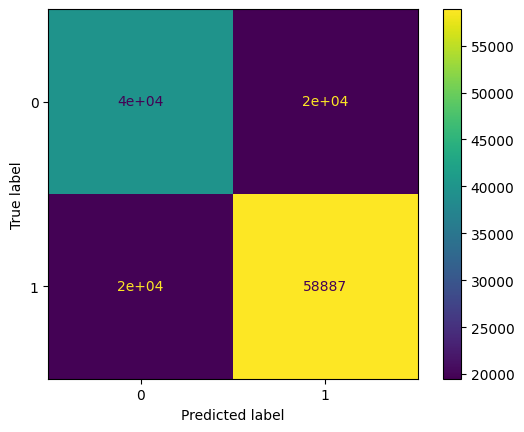

In [56]:
confusion_matrix_dt_textvector = m.ConfusionMatrixDisplay.from_predictions(y_temp, dt_textvector_predict)
confusion_matrix_dt_textvector

#Word2Vec

In [14]:
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, size=200, window=5, min_count=1, workers=4):
        self.size = size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.model = None

    def fit(self, X, y=None):
        sentences = [text.split() for text in X]
        self.model = Word2Vec(sentences, vector_size=self.size, window=self.window, min_count=self.min_count, workers=self.workers)
        return self

    def transform(self, X, y=None):
        sentences = [text.split() for text in X]
        X_transformed = np.array([np.mean([self.model.wv[word] for word in sentence if word in self.model.wv]
                                          or [np.zeros(self.size)], axis=0) for sentence in sentences])
        return X_transformed
class PositiveScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = MinMaxScaler(feature_range=(0, 1))

    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self

    def transform(self, X, y=None):
        return self.scaler.transform(X)

In [15]:
word2vec = Word2VecTransformer()
word2vec.fit(x_train)

#DL
x_train_word2vec = word2vec.transform(x_train)
x_val_word2vec = word2vec.transform(x_val)
x_test_word2vec = word2vec.transform(x_test)

#ML
x_temp_word2vec = word2vec.transform(x_temp)


#Bi - LSTM Word2Vec

In [16]:
activation_function = 'tanh'
input_shape = x_train_word2vec.shape[1]

inputs = Input(shape=(input_shape,))
x = tf.expand_dims(inputs, axis=-1)
x = Bidirectional(LSTM(256, return_sequences=True))(x)
x = GlobalAveragePooling1D()(x)
x = Dense(units=500, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=200, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=100, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=50, activation=activation_function)(x)
outputs = Dense(len(set(df['target'])), activation="sigmoid")(x)

bilstm_word2vec = tf.keras.Model(inputs, outputs)

bilstm_word2vec.compile(loss="binary_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])
bilstm_word2vec.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 tf.expand_dims (TFOpLambda  (None, 200, 1)            0         
 )                                                               
                                                                 
 bidirectional (Bidirection  (None, 200, 512)          528384    
 al)                                                             
                                                                 
 global_average_pooling1d (  (None, 512)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 500)               256500    
                                                             

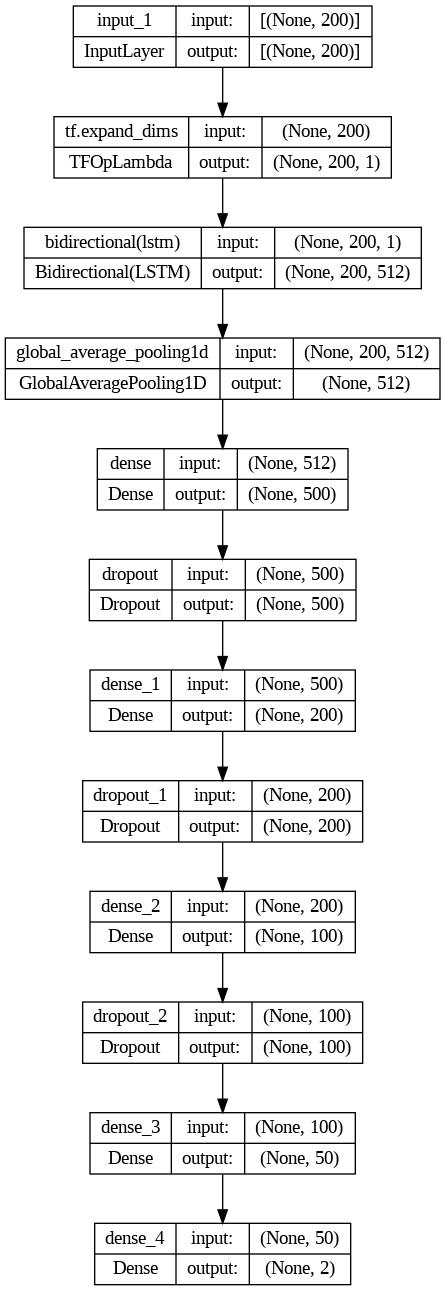

In [17]:
from keras.utils import plot_model

# assuming your model is named 'model'
plot_model(bilstm_word2vec, to_file='bilstm_word2vec.png', show_shapes=True, show_layer_names=True)


In [18]:
history = bilstm_word2vec.fit(x_train_word2vec, y_train_one_hot,
                           epochs=100,
                           validation_data= (x_val_word2vec, y_val_one_hot),
                           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])

Epoch 1/100
17235/17235 [==============================] - 422s 24ms/step - loss: 0.4697 - accuracy: 0.7818 - val_loss: 0.4163 - val_accuracy: 0.8164
Epoch 2/100
17235/17235 [==============================] - 406s 24ms/step - loss: 0.4144 - accuracy: 0.8166 - val_loss: 0.4243 - val_accuracy: 0.8110
Epoch 3/100
17235/17235 [==============================] - 408s 24ms/step - loss: 0.4016 - accuracy: 0.8244 - val_loss: 0.4102 - val_accuracy: 0.8274
Epoch 4/100
17235/17235 [==============================] - 407s 24ms/step - loss: 0.4754 - accuracy: 0.7773 - val_loss: 0.4714 - val_accuracy: 0.7590
Epoch 5/100
17235/17235 [==============================] - 407s 24ms/step - loss: 0.4437 - accuracy: 0.8005 - val_loss: 0.4231 - val_accuracy: 0.8159
Epoch 6/100
17235/17235 [==============================] - 406s 24ms/step - loss: 0.4301 - accuracy: 0.8089 - val_loss: 0.4278 - val_accuracy: 0.8039
Epoch 7/100
17235/17235 [==============================] - 406s 24ms/step - loss: 0.4212 - accuracy:

In [19]:
loss, accuracy = bilstm_word2vec.evaluate(x_val_word2vec, y_val_one_hot)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

2155/2155 [==============================] - 22s 10ms/step - loss: 0.4198 - accuracy: 0.8144
Test loss: 0.41975176334381104
Test accuracy: 0.8143694400787354


In [23]:
bilstm_word2vec_pred_probs = bilstm_word2vec.predict(x_test_word2vec)

bilstm_word2vec_preds = tf.argmax(bilstm_word2vec_pred_probs, axis=1)

bilstm_word2vec_results = calculate_results(y_true=y_test,
                                    y_pred=bilstm_word2vec_preds)
bilstm_word2vec_results

2155/2155 [==============================] - 20s 9ms/step


{'accuracy': 0.8165453015753286,
 'precision': 0.8173412100333058,
 'recall': 0.8165453015753286,
 'f1': 0.8168267179502692}

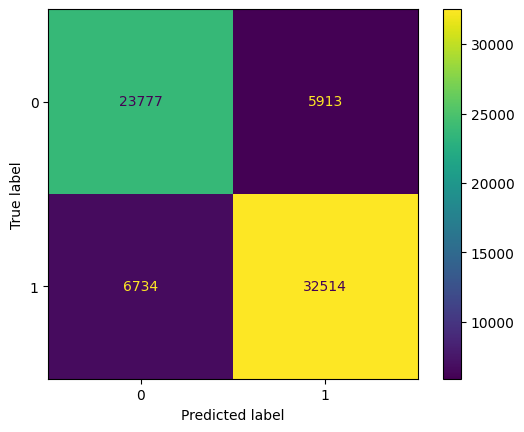

In [62]:
confusion_matrix_bilstm_word2vec = m.ConfusionMatrixDisplay.from_predictions(y_test, bilstm_word2vec_preds)
confusion_matrix_bilstm_word2vec

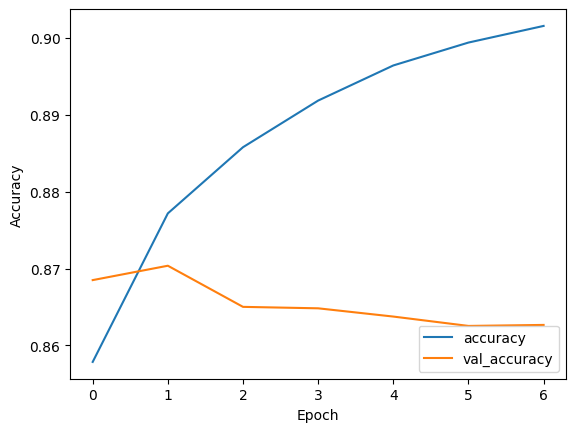

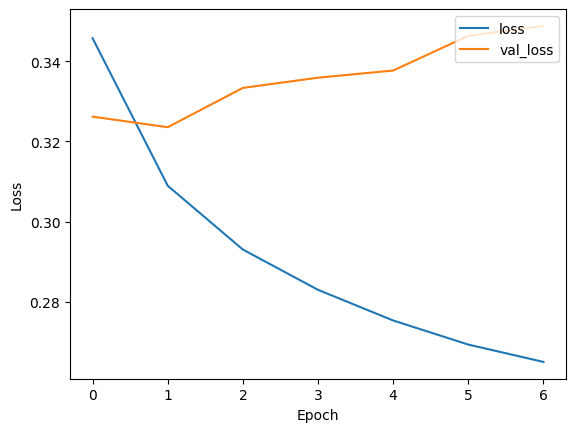

In [63]:
# Biểu đồ độ chính xác
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Biểu đồ hàm mất mát
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [27]:
joblib.dump(bilstm_word2vec, '/content/gdrive/MyDrive/Tieu_luan/model_BiLSTM_word2vec.pkl')

['/content/gdrive/MyDrive/Tieu_luan/model_BiLSTM_word2vec.pkl']

#Naive Bayes Word2Vec

In [33]:
bayes_word2vec = Pipeline([
    ("scaler", PositiveScaler()),
    ("clf", MultinomialNB(fit_prior = True,
                          alpha = 0.01))
])

bayes_word2vec.fit(x_train_word2vec, y_train)

Pipeline(steps=[('scaler', PositiveScaler()),
                ('clf', MultinomialNB(alpha=0.01))])

In [34]:
bayes_word2vec_predict = bayes_word2vec.predict(x_temp_word2vec)

bayes_word2vec_results = calculate_results(y_true=y_temp,
                                     y_pred=bayes_word2vec_predict)
bayes_word2vec_results

{'accuracy': 0.6624358118889437,
 'precision': 0.7268572418100776,
 'recall': 0.6624358118889437,
 'f1': 0.6079971154555713}

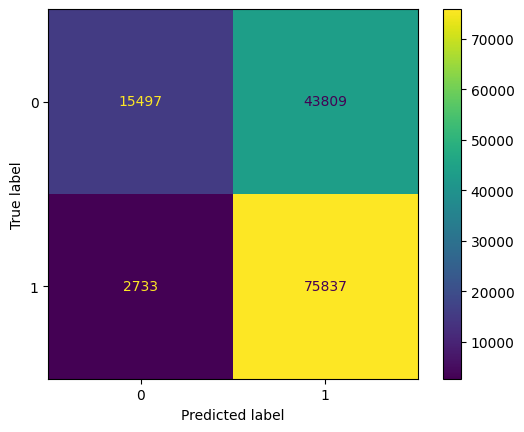

In [35]:
confusion_matrix_bayes_doc2vec = m.ConfusionMatrixDisplay.from_predictions(y_temp, bayes_word2vec_predict)
confusion_matrix_bayes_doc2vec

#Decision Tree Word2Vec

In [30]:
dt_word2vec = DecisionTreeClassifier(min_samples_split=10,
                                           min_samples_leaf=1,
                                           max_depth=20,
                                           criterion = 'entropy')

dt_word2vec.fit(x_train_word2vec, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=10)

In [31]:
dt_word2vec_predict = dt_word2vec.predict(x_temp_word2vec)

dt_word2vec_results = calculate_results(y_true=y_temp,
                                     y_pred=dt_word2vec_predict)
dt_word2vec_results

{'accuracy': 0.7730424439351301,
 'precision': 0.7734528373872908,
 'recall': 0.7730424439351301,
 'f1': 0.7732215886528759}

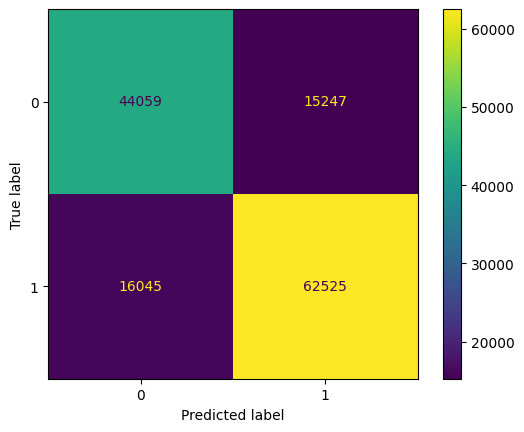

In [32]:
confusion_matrix_dt_doc2vec = m.ConfusionMatrixDisplay.from_predictions(y_temp, dt_word2vec_predict)
confusion_matrix_dt_doc2vec

#TF - IDF

In [ ]:
tfidf = TfidfVectorizer(max_features=1000)

In [ ]:
x_train_tfidf = tfidf.fit_transform(x_train_list)

In [ ]:
tf_idf_array = x_train_tfidf.toarray()
words_set = tfidf.get_feature_names_out()
df_tf_idf = pd.DataFrame(tf_idf_array, columns = words_set)

df_tf_idf

In [ ]:
train_dataset_tfidf = tf.data.Dataset.from_tensor_slices((x_train_tfidf, y_train))


ValueError: TypeError: sparse array length is ambiguous; use getnnz() or shape[0]
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/util/structure.py", line 105, in normalize_element
    spec = type_spec_from_value(t, use_fallback=False)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/util/structure.py", line 514, in type_spec_from_value
    raise TypeError("Could not build a `TypeSpec` for {} with type {}".format(

TypeError: Could not build a `TypeSpec` for   (0, 3554)	0.26440817122587656
  (0, 3862)	0.3796694160169036
  (0, 2721)	0.3861055106678382
  (0, 1609)	0.3007713619974377
  (0, 2623)	0.6922113896298274
  (0, 4128)	0.25931056289948634
  (2, 3709)	0.8544445586608517
  (2, 3134)	0.3187674093346089
  (2, 1845)	0.41025825393398785
  (3, 941)	0.2600905430185077
  (3, 2219)	0.19518837768795783
  (3, 3688)	0.2841790703480779
  (3, 2974)	0.2896848853436494
  (3, 421)	0.3609923571359954
  (3, 2717)	0.23984515953905902
  (3, 218)	0.31567356745223873
  (3, 654)	0.27138992253226685
  (3, 1640)	0.43750607383451745
  (3, 2255)	0.22270087694512072
  (3, 4108)	0.2872037251751634
  (3, 3010)	0.21199677151715696
  (4, 1189)	0.9012404741804392
  (4, 4108)	0.43331929070723046
  (5, 2799)	0.803507711773857
  (5, 4128)	0.595294344942013
  :	:
  (551498, 4943)	0.4657535896409081
  (551498, 679)	0.22744819701905492
  (551498, 718)	0.27096503464541555
  (551498, 3556)	0.31235997414599753
  (551498, 11)	0.39126115090163244
  (551498, 2327)	0.4190031221261459
  (551499, 2535)	0.5984474654266395
  (551499, 1112)	0.48442692040016416
  (551499, 1407)	0.37796289412824075
  (551499, 4128)	0.5141354301915485
  (551500, 272)	0.474931381556096
  (551500, 35)	0.4797883656415119
  (551500, 2555)	0.42045217340325947
  (551500, 4797)	0.6061874931807322
  (551501, 3412)	0.5151601346580712
  (551501, 1365)	0.447199008676211
  (551501, 1902)	0.37746265485023367
  (551501, 3682)	0.3443654555031099
  (551501, 2191)	0.37007261183810386
  (551501, 395)	0.18157580526091227
  (551501, 2489)	0.20867435222122105
  (551501, 3556)	0.24513050235307424
  (551502, 503)	0.7389391741648018
  (551502, 518)	0.5819143556574484
  (551502, 3134)	0.33962417399887423 with type csr_matrix


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/scipy/sparse/_base.py", line 340, in __len__
    raise TypeError("sparse array length is ambiguous; use getnnz()"

TypeError: sparse array length is ambiguous; use getnnz() or shape[0]



In [ ]:
vocab_tfidf = tfidf.vocabulary_
len(vocab_tfidf)

59507

In [ ]:
# train_dataset_tfidf = tf.data.Dataset.from_tensor_slices((x_train_tfidf, y_train_one_hot))
# valid_dataset_tfidf = tf.data.Dataset.from_tensor_slices((x_val_tfidf, y_val_one_hot))
# test_dataset_tfidf = tf.data.Dataset.from_tensor_slices((x_test_tfidf, y_test_one_hot))

# train_dataset_tfidf

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(2,), dtype=tf.float32, name=None))>

In [ ]:
train_dataset_tfidf = train_dataset_tfidf.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset_tfidf = valid_dataset_tfidf.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_tfidf = test_dataset_tfidf.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset_tfidf

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [ ]:
token_embedding = Embedding(input_dim = len(vocab_tfidf),
                           output_dim = output_len,
                           mask_zero=True,
                           name="token_embedding")

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

tfidf= TextVectorization(output_mode='tf-idf')
tfidf.adapt(x_train_list)

#Bi - LSTM TF - IDF

In [ ]:
activation_function = 'tanh'

inputs = Input(shape=(1,), dtype=tf.string)
text_vectors = tfidf(inputs)
token_embeddings = token_embedding(text_vectors)

x = Bidirectional(LSTM(256, return_sequences=True))(token_embeddings)
x = GlobalAveragePooling1D()(x)
x = Dense(units=500, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=200, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=100, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=50, activation=activation_function)(x)
outputs = Dense(len(set(df['target'])), activation="sigmoid")(x)

bilstm_tfidf = tf.keras.Model(inputs, outputs)


bilstm_tfidf.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

bilstm_tfidf.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 59040)             1         
 Vectorization)                                                  
                                                                 
 token_embedding (Embedding  (None, 59040, 171)        10175697  
 )                                                               
                                                                 
 bidirectional_3 (Bidirecti  (None, 59040, 512)        876544    
 onal)                                                           
                                                                 
 global_average_pooling1d_2  (None, 512)               0         
  (GlobalAveragePooling1D)                                 

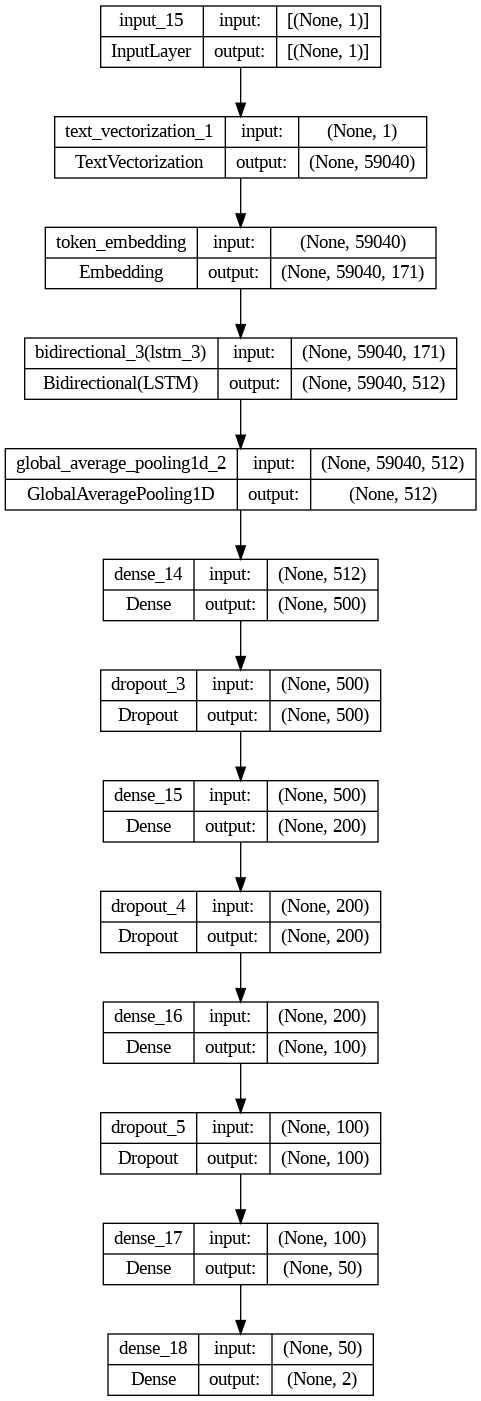

In [ ]:
from keras.utils import plot_model

# assuming your model is named 'model'
plot_model(bilstm_tfidf, to_file='bilstm_tfidf.png', show_shapes=True, show_layer_names=True)


In [ ]:
history = bilstm_tfidf.fit(train_dataset_tfidf,
                           epochs=100,
                           validation_data= valid_dataset_tfidf,
                           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])

bilstm_tfidf.evaluate(valid_dataset_tfidf)

Epoch 1/100


In [ ]:
import joblib
joblib.dump(model_bilstm, '/content/gdrive/MyDrive/Tieu_luan/Model/model_BiLSTM_tfidf.pkl')


In [ ]:
import joblib
joblib.dump(bilstm_tfidf, '/content/gdrive/MyDrive/Tieu_luan/data/model_BiLSTM.pkl')

!mkdir -p saved_model

bilstm_tfidf.save('saved_model/my_model')
!ls saved_model

!ls saved_model/my_model

In [ ]:
bilstm_tfidf_pred_probs = bilstm_tfidf.predict(test_dataset)

bilstm_tfidf_preds = tf.argmax(bilstm_tfidf_pred_probs, axis=1)

bilstm_tfidf_results = calculate_results(y_true=y_test,
                                    y_pred=bilstm_tfidf_preds)
bilstm_tfidf_results

In [ ]:
from sklearn import metrics as m

confusion_matrix_bilstm_tfidf = m.ConfusionMatrixDisplay.from_predictions(y_test, bilstm_tfidf_preds)
confusion_matrix_bilstm_tfidf

In [ ]:
import matplotlib.pyplot as plt

# Biểu đồ độ chính xác
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Biểu đồ hàm mất mát
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


#Naive Bayes TF - IDF

In [ ]:
# Create a pipeline
bayes_tfidf = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
bayes_tfidf.fit(X=x_train,
            y=y_train);

In [ ]:
bayes_tfidf_predict = bayes_tfidf.predict(x_temp)

bayes_tfidf_results = calculate_results(y_true=y_temp,
                                     y_pred=bayes_tfidf_predict)
bayes_tfidf_results

{'accuracy': 0.8290130261974528,
 'precision': 0.8288659630849511,
 'recall': 0.8290130261974528,
 'f1': 0.8289302685553078}

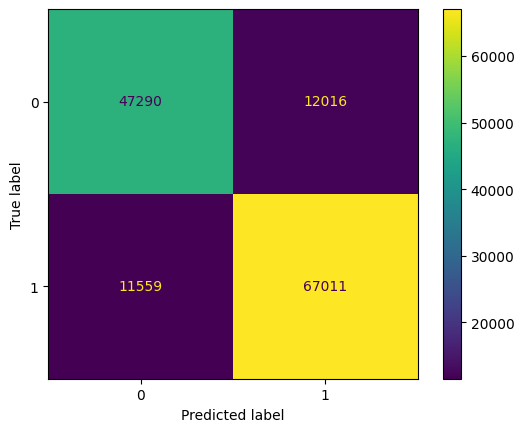

In [ ]:
from sklearn import metrics as m

confusion_matrix_bayes_tfidf = m.ConfusionMatrixDisplay.from_predictions(y_temp, bayes_tfidf_predict)
confusion_matrix_bayes_tfidf

#Decision tree TF - IDF

In [ ]:
# Create a pipeline
dt_tfidf = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", DecisionTreeClassifier(max_depth=50))
])

# Xây dựng cây quyết định
dt_tfidf.fit(x_train, y_train)


Pipeline(steps=[('tf-idf', TfidfVectorizer()),
                ('clf', DecisionTreeClassifier(max_depth=50))])

In [ ]:
dt_tfidf_predict = dt_tfidf.predict(x_temp)

dt_tfidf_results = calculate_results(y_true=y_temp,
                                     y_pred=dt_tfidf_predict)
dt_tfidf_results

{'accuracy': 0.8034320693956889,
 'precision': 0.8030500488397807,
 'recall': 0.8034320693956889,
 'f1': 0.8020975243162825}

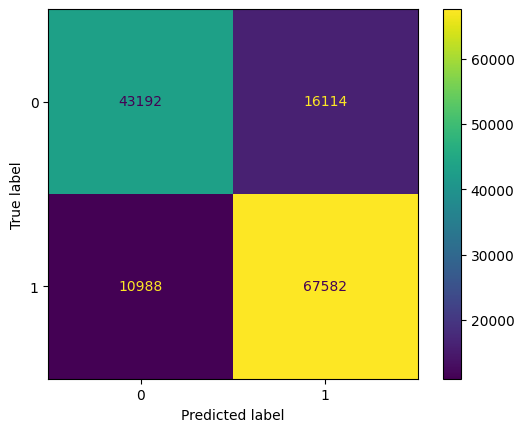

In [ ]:
from sklearn import metrics as m

confusion_matrix_dt_tfidf = m.ConfusionMatrixDisplay.from_predictions(y_temp, dt_tfidf_predict)
confusion_matrix_dt_tfidf

#Doc2vec

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tagged_data = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(x_train)]
# Bước 2: Tạo mô hình Doc2Vec
model_d2v = Doc2Vec(vector_size=max_tokens)
model_d2v.build_vocab(tagged_data)
model_d2v.train(tagged_data, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)

KeyboardInterrupt: 

In [ ]:
X_train_d2v = np.array([model_d2v.infer_vector(doc.split()) for doc in x_train])
X_val_d2v = np.array([model_d2v.infer_vector(doc.split()) for doc in x_val])
X_test_d2v = np.array([model_d2v.infer_vector(doc.split()) for doc in x_test])
X_test_d2v_ml = np.array([model_d2v.infer_vector(doc.split()) for doc in x_temp])


#Naive Bayes doc2vec

In [ ]:
bayes_doc2vec = MultinomialNB()
bayes_doc2vec.fit(X_train_d2v, y_train)

In [ ]:
bayes_doc2vec_predict = bayes_doc2vec.predict(X_test_d2v_ml)

bayes_doc2vec_results = calculate_results(y_true=y_temp,
                                     y_pred=bayes_doc2vec_predict)
bayes_doc2vec_results

In [ ]:
from sklearn import metrics as m

confusion_matrix_bayes_doc2vec = m.ConfusionMatrixDisplay.from_predictions(y_test, bayes_doc2vec_predict)
confusion_matrix_bayes_doc2vec

#Decision tree doc2vec

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from gensim.sklearn_api import D2VTransformer

# Create a pipeline
dt_d2v = Pipeline([
    ("doc2vec", D2VTransformer(vector_size=max_tokens)),  # Sử dụng D2VTransformer để chuyển đổi văn bản thành vector
    ("clf", DecisionTreeClassifier(max_depth=50))
])

# Xây dựng cây quyết định
dt_d2v.fit(x_train, y_train)


In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

class Doc2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=max_tokens, epochs=20):
        self.vector_size = vector_size
        self.epochs = epochs
        self.model = None

    def fit(self, X, y=None):
        tagged_data = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(X)]
        self.model = Doc2Vec(vector_size=self.vector_size, epochs=self.epochs)
        self.model.build_vocab(tagged_data)
        self.model.train(tagged_data, total_examples=self.model.corpus_count, epochs=self.model.epochs)
        return self

    def transform(self, X, y=None):
        vectors = []
        for doc in X:
            vectors.append(self.model.infer_vector(doc.split()))
        return vectors

# Create a pipeline
dt_d2v = Pipeline([
    ("doc2vec", Doc2VecTransformer(vector_size=max_tokens)),
    ("clf", DecisionTreeClassifier(max_depth=50))
])

# Fit the decision tree
dt_d2v.fit(x_train, y_train)


In [ ]:
dt_doc2vec = DecisionTreeClassifier()
dt_doc2vec.fit(X_train_d2v, y_train)

In [ ]:
dt_doc2vec_predict = dt_doc2vec.predict(x_test)

dt_doc2vec_results = calculate_results(y_true=y_test,
                                     y_pred=dt_doc2vec_predict)
dt_doc2vec_results

In [ ]:
from sklearn import metrics as m

confusion_matrix_dt_doc2vec = m.ConfusionMatrixDisplay.from_predictions(y_test, dt_doc2vec_predict)
confusion_matrix_dt_doc2vec

#Tổng hợp

In [71]:
results = {
    "TextVectorization Bi - LSTM": model_bilstm_results,
    "TextVectorization Naive Bayes": bayes_textvector_results,
    "TextVectorization Decision Tree": dt_textvector_results,
    "Word2Vec Bi - LSTM": bilstm_word2vec_results,
    "Word2Vec Naive Bayes": bayes_word2vec_results,
    "Word2Vec Decision Tree": dt_word2vec_results
}

results_df = pd.DataFrame(results).T

results_df_rounded = results_df.round(4)

print(results_df_rounded)

                                 accuracy  precision  recall      f1
TextVectorization Bi - LSTM        0.8613     0.8618  0.8613  0.8615
TextVectorization Naive Bayes      0.6288     0.6277  0.6288  0.6017
TextVectorization Decision Tree    0.7158     0.7159  0.7158  0.7158
Word2Vec Bi - LSTM                 0.8165     0.8173  0.8165  0.8168
Word2Vec Naive Bayes               0.6624     0.7269  0.6624  0.6080
Word2Vec Decision Tree             0.7730     0.7735  0.7730  0.7732


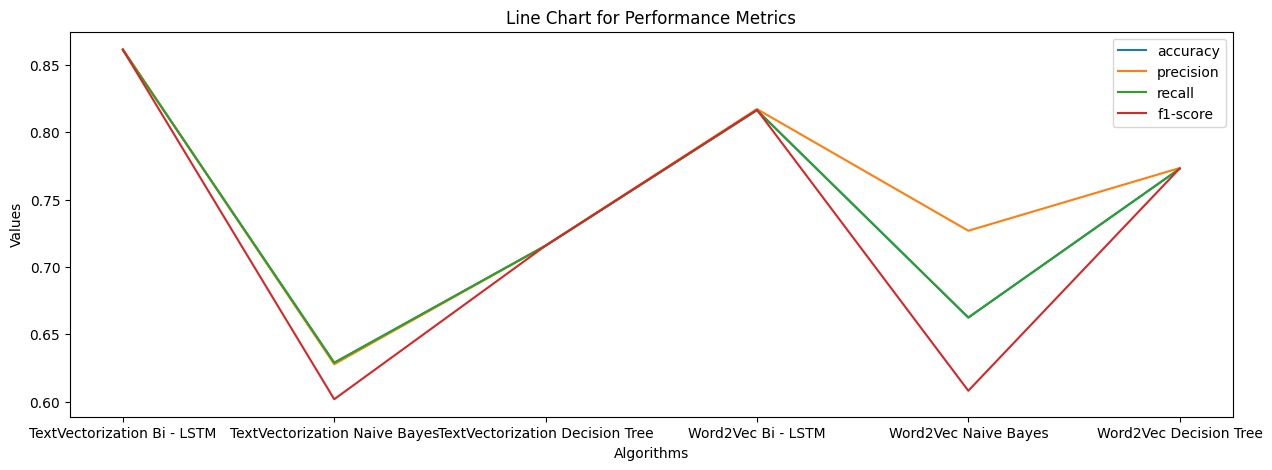

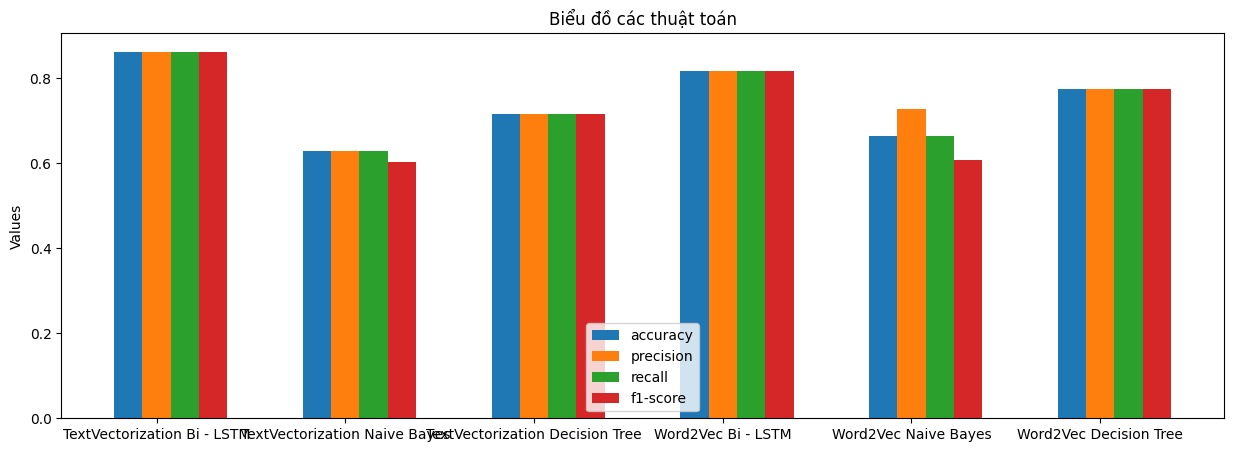

In [81]:
import matplotlib.pyplot as plt

metrics = {
    'TextVectorization Bi - LSTM': {'accuracy': 0.8613, 'precision': 0.8618  , 'recall': 0.8613, 'f1-score': 0.8615},
    'TextVectorization Naive Bayes': {'accuracy': 0.6288, 'precision': 0.6277, 'recall': 0.6288, 'f1-score': 0.6017},
    'TextVectorization Decision Tree': {'accuracy': 0.7158, 'precision': 0.7159, 'recall': 0.7158, 'f1-score': 0.7158},
    'Word2Vec Bi - LSTM': {'accuracy': 0.8165, 'precision': 0.8173, 'recall': 0.8165, 'f1-score': 0.8168},
    'Word2Vec Naive Bayes': {'accuracy': 0.6624, 'precision': 0.7269, 'recall': 0.6624, 'f1-score': 0.6080},
    'Word2Vec Decision Tree': {'accuracy': 0.7730, 'precision': 0.7735, 'recall': 0.7730, 'f1-score': 0.7732}
    # Thêm các thuật toán khác nếu bạn muốn
}

# Vẽ biểu đồ đường cho từng chỉ số
plt.figure(figsize=(15, 5))
for metric in ['accuracy', 'precision', 'recall', 'f1-score']:
    plt.plot(metrics.keys(), [values[metric] for values in metrics.values()], label=metric)
plt.title('Line Chart for Performance Metrics')
plt.xlabel('Algorithms')
plt.ylabel('Values')
plt.legend()
plt.show()

# Vẽ biểu đồ cột cho từng chỉ số
fig, ax = plt.subplots(figsize=(15, 5))
width = 0.15
algorithms = list(metrics.keys())
for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1-score']):
    ax.bar([x + i*width for x in range(len(algorithms))], [values[metric] for values in metrics.values()], width=width, label=metric)
ax.set_title('Biểu đồ các thuật toán')
ax.set_xticks([x + width for x in range(len(algorithms))])
ax.set_xticklabels(algorithms)
ax.set_ylabel('Values')
ax.legend()
plt.show()


In [ ]:
# results = {
#     "TF - IDF Bi - LSTM": model_bilstm_results,
#     "TF - IDF Naive Bayes": bayes_tfidf,
#     "TF - IDF Decision Tree": dt_tfidf,
#     "Doc2vec Bi - LSTM": bilstm_doc2vec,
#     "Doc2vec Naive Bayes": bayes_doc2vec,
#     "Doc2vec Decision Tree": dt_doc2vec

# }

# # Chuyển kết quả thành DataFrame
# results_df = pd.DataFrame(results).T

# # In kết quả
# print(results_df)

# dùng 10 test, 80 train cho ml

               accuracy  precision    recall        f1
Bi - LSTM      0.866043   0.866389  0.866043  0.866171
Naive Bayes    0.831888   0.831676  0.831888  0.831759
Decision Tree  0.803408   0.803244  0.803408  0.801857


In [ ]:
# results = {
#     # " Bi - LSTM": model_bilstm_results,
#     "TF - IDF Naive Bayes": bayes_tfidf_results,
#     "TF - IDF Decision Tree": dt_tfidf_results,
#     "TextVectorization Naive Bayes": bayes_textvector_results,
#     "TextVectorization Decision Tree": dt_textvector_results
# }

# # Chuyển kết quả thành DataFrame
# results_df = pd.DataFrame(results).T

# # In kết quả
# print(results_df)

# # dùng 20 test, 80 train cho ml

                                 accuracy  precision    recall        f1
TF - IDF Naive Bayes             0.830107   0.829917  0.830107  0.829996
TF - IDF Decision Tree           0.801656   0.801336  0.801656  0.800126
TextVectorization Naive Bayes    0.629316   0.627662  0.629316  0.602409
TextVectorization Decision Tree  0.697041   0.697223  0.697041  0.697129


In [ ]:
# results = {
#     "TextVectorization Bi - LSTM": model_bilstm_results,
#     # "TextVectorization Naive Bayes": bayes_textvector_results,
#     # "TextVectorization Decision Tree": dt_textvector_results,
#     # "TF - IDF Bi - LSTM": model_bilstm_results,
#     "TF - IDF Naive Bayes": bayes_tfidf_results,
#     "TF - IDF Decision Tree": dt_tfidf_results,


# }

# # Chuyển kết quả thành DataFrame
# results_df = pd.DataFrame(results).T

# # In kết quả
# print(results_df)

                             accuracy  precision    recall        f1
TextVectorization Bi - LSTM  0.863849   0.863799  0.863849  0.863822
TF - IDF Naive Bayes         0.829013   0.828866  0.829013  0.828930
TF - IDF Decision Tree       0.803432   0.803050  0.803432  0.802098


In [ ]:
# results = {
#     "TextVectorization Bi - LSTM": model_bilstm_results,
#     "TextVectorization Naive Bayes": bayes_textvector_results,
#     "TextVectorization Decision Tree": dt_textvector_results,
#     # "TF - IDF Bi - LSTM": model_bilstm_results,
#     "TF - IDF Naive Bayes": bayes_tfidf_results,
#     "TF - IDF Decision Tree": dt_tfidf_results,


# }

# # Chuyển kết quả thành DataFrame
# results_df = pd.DataFrame(results).T

# # In kết quả
# print(results_df)

                                 accuracy  precision    recall        f1
TextVectorization Bi - LSTM      0.863849   0.863799  0.863849  0.863822
TextVectorization Naive Bayes    0.628775   0.627743  0.628775  0.601745
TextVectorization Decision Tree  0.696836   0.697347  0.696836  0.697070
TF - IDF Naive Bayes             0.829013   0.828866  0.829013  0.828930
TF - IDF Decision Tree           0.803432   0.803050  0.803432  0.802098


#SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

pipeline = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("svc", SVC())
])
parameters = {
    "svc__C": [0.1, 1, 10],
    "svc__kernel": ["linear", "rbf"]
}


grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X=x_train, y=y_train)
print("Best parameters:", grid_search.best_params_)

model_svm = grid_search.best_estimator_


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
model_svm_predict = model_svm.predict(x_test)

model_svm_results = calculate_results(y_true=y_test,
                                     y_pred=model_svm_predict)
model_svm_results


In [ ]:
from sklearn import metrics as m

confusion_matrix_svm = m.ConfusionMatrixDisplay.from_predictions(y_test, model_svm_predict)
confusion_matrix_svm

#TEST

In [ ]:
history = model_bilstm.fit(train_dataset,
                           epochs=100,
                           validation_data= valid_dataset,
                           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])

model_bilstm.evaluate(valid_dataset)

Epoch 1/100
17235/17235 [==============================] - 469s 26ms/step - loss: 0.3463 - accuracy: 0.8573 - val_loss: 0.3242 - val_accuracy: 0.8683
Epoch 2/100
17235/17235 [==============================] - 401s 23ms/step - loss: 0.3091 - accuracy: 0.8774 - val_loss: 0.3234 - val_accuracy: 0.8691
Epoch 3/100
17235/17235 [==============================] - 393s 23ms/step - loss: 0.2932 - accuracy: 0.8856 - val_loss: 0.3271 - val_accuracy: 0.8691
Epoch 4/100
17235/17235 [==============================] - 398s 23ms/step - loss: 0.2831 - accuracy: 0.8916 - val_loss: 0.3349 - val_accuracy: 0.8672
Epoch 5/100
17235/17235 [==============================] - 385s 22ms/step - loss: 0.2764 - accuracy: 0.8955 - val_loss: 0.3457 - val_accuracy: 0.8657
Epoch 6/100
17235/17235 [==============================] - 414s 24ms/step - loss: 0.2714 - accuracy: 0.8986 - val_loss: 0.3463 - val_accuracy: 0.8662
Epoch 7/100
2155/2155 [==============================] - 17s 8ms/step - loss: 0.3504 - accuracy: 0.8

[0.35044169425964355, 0.8621950149536133]

In [ ]:
model_bilstm_pred_probs = model_bilstm.predict(test_dataset)

model_bilstm_preds = tf.argmax(model_bilstm_pred_probs, axis=1)

model_bilstm_results = calculate_results(y_true=y_test,
                                    y_pred=model_bilstm_preds)
model_bilstm_results

2155/2155 [==============================] - 20s 8ms/step


{'accuracy': 0.863761640894717,
 'precision': 0.8639609409206302,
 'recall': 0.863761640894717,
 'f1': 0.8638443009960143}

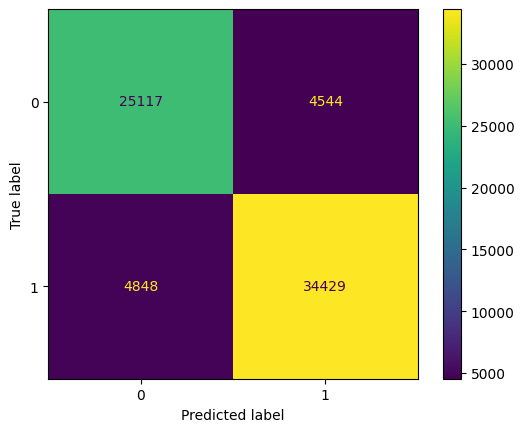

In [ ]:
from sklearn import metrics as m

confusion_matrix_bilstm = m.ConfusionMatrixDisplay.from_predictions(y_test, model_bilstm_preds)
confusion_matrix_bilstm

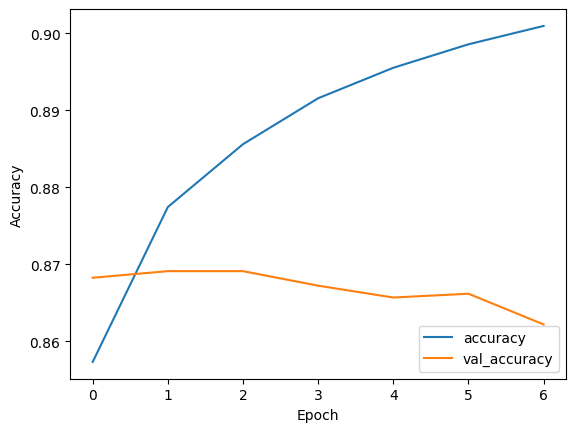

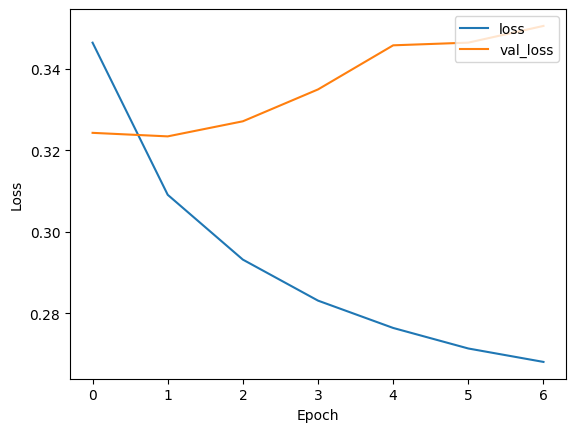

In [ ]:
import matplotlib.pyplot as plt

# Biểu đồ độ chính xác
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Biểu đồ hàm mất mát
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [ ]:
# tạo số cột tương ứng với số lượng thuộc tính của y => 2 cột y được tạo
y_train_one_hot = tf.one_hot(y_train.to_numpy(), depth=len(set(y)))
y_val_one_hot = tf.one_hot(y_val.to_numpy(), depth=len(set(y)))
y_test_one_hot = tf.one_hot(y_test.to_numpy(), depth=len(set(y)))

y_train_one_hot

<tf.Tensor: shape=(552532, 2), dtype=float32, numpy=
array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)>

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_list, y_train_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((x_val_list, y_val_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_list, y_test_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(2,), dtype=tf.float32, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [ ]:
token_embedding = Embedding(input_dim = len(vocab),
                           output_dim = output_len,
                           mask_zero=True,
                           name="token_embedding")

In [ ]:
# Define the model parameters
# embedding_dim = 30  # Embedding dimension
# dropout_threshold = 0.5  # Dropout rate for the LSTM layers
# output_size = 256
# activation_function = 'relu'  # Activation function for the LSTM layers
# batch_size = 256  # Batch size
# num_epochs = 100  # Number of training epochs
# loss_function = 'binary_crossentropy'  # Loss function
# learning_rate = 0.002  # Learning rate
# optimizer_name = 'Adam'  # Optimizer name
activation_function = 'tanh'

inputs = Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embedding(text_vectors)

x = Bidirectional(LSTM(256, return_sequences=True))(token_embeddings)
x = GlobalAveragePooling1D()(x)
x = Dense(units=500, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=400, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=300, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=200, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=100, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=50, activation=activation_function)(x)
outputs = Dense(len(set(df['target'])), activation="sigmoid")(x)

model_bilstm = tf.keras.Model(inputs, outputs)


model_bilstm.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_bilstm.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 171)               0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 171, 171)          10233324  
 )                                                               
                                                                 
 bidirectional (Bidirection  (None, 171, 512)          876544    
 al)                                                             
                                                                 
 global_average_pooling1d (  (None, 512)               0         
 GlobalAveragePooling1D)                                     

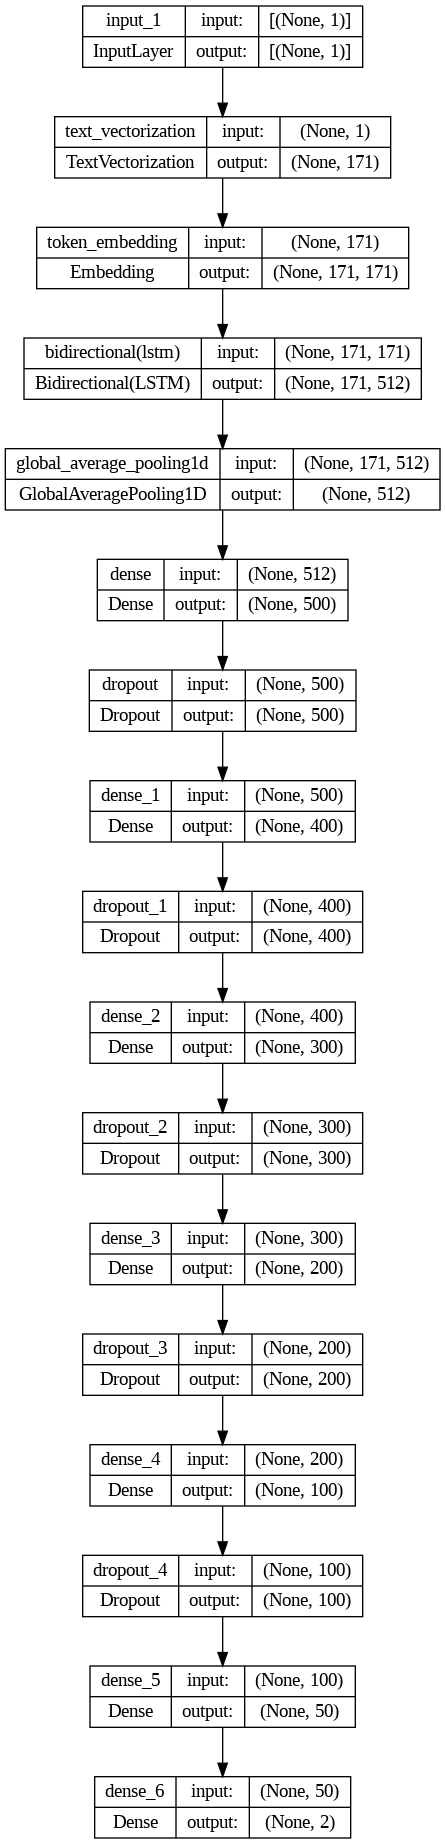

In [ ]:
from keras.utils import plot_model
plot_model(model_bilstm, to_file='model_test.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model_bilstm.fit(train_dataset,
                           epochs=100,
                           batch_size=256,
                           validation_data= valid_dataset,
                           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])

model_bilstm.evaluate(valid_dataset)

Epoch 1/100
2159/2159 [==============================] - 154s 64ms/step - loss: 0.3548 - accuracy: 0.8535 - val_loss: 0.3421 - val_accuracy: 0.8629
Epoch 2/100
2159/2159 [==============================] - 90s 42ms/step - loss: 0.3083 - accuracy: 0.8772 - val_loss: 0.3305 - val_accuracy: 0.8667
Epoch 3/100
2159/2159 [==============================] - 89s 41ms/step - loss: 0.2876 - accuracy: 0.8881 - val_loss: 0.3322 - val_accuracy: 0.8657
Epoch 4/100
2159/2159 [==============================] - 87s 40ms/step - loss: 0.2727 - accuracy: 0.8951 - val_loss: 0.3435 - val_accuracy: 0.8648
Epoch 5/100
2159/2159 [==============================] - 87s 40ms/step - loss: 0.2632 - accuracy: 0.8998 - val_loss: 0.3561 - val_accuracy: 0.8621
Epoch 6/100
2159/2159 [==============================] - 87s 40ms/step - loss: 0.2557 - accuracy: 0.9029 - val_loss: 0.3607 - val_accuracy: 0.8604
Epoch 7/100
270/270 [==============================] - 5s 19ms/step - loss: 0.3530 - accuracy: 0.8621


[0.3529989719390869, 0.8621193766593933]

In [ ]:
# Define the model parameters
# embedding_dim = 30  # Embedding dimension
# dropout_threshold = 0.5  # Dropout rate for the LSTM layers
# output_size = 256
# activation_function = 'relu'  # Activation function for the LSTM layers
# batch_size = 256  # Batch size
# num_epochs = 100  # Number of training epochs
# loss_function = 'binary_crossentropy'  # Loss function
# learning_rate = 0.002  # Learning rate
# optimizer_name = 'Adam'  # Optimizer name
activation_function = 'tanh'

inputs = Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embedding(text_vectors)

x = LSTM(256, return_sequences=True)(token_embeddings)
x = GlobalAveragePooling1D()(x)
x = Dense(units=500, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=200, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=100, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=50, activation=activation_function)(x)
outputs = Dense(len(set(df['target'])), activation="sigmoid")(x)

model_lstm = tf.keras.Model(inputs, outputs)


model_lstm.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_lstm.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 171)               0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 171, 171)          10233324  
 )                                                               
                                                                 
 lstm_3 (LSTM)               (None, 171, 256)          438272    
                                                                 
 global_average_pooling1d_3  (None, 256)               0         
  (GlobalAveragePooling1D)                                       
                                                           

In [ ]:
history = model_lstm.fit(train_dataset,
                           epochs=100,
                           batch_size=32,
                           validation_data= valid_dataset,
                           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])

model_lstm.evaluate(valid_dataset)

Epoch 1/100
17267/17267 [==============================] - 320s 17ms/step - loss: 0.3477 - accuracy: 0.8572 - val_loss: 0.3288 - val_accuracy: 0.8653
Epoch 2/100
17267/17267 [==============================] - 245s 14ms/step - loss: 0.3100 - accuracy: 0.8768 - val_loss: 0.3250 - val_accuracy: 0.8668
Epoch 3/100
17267/17267 [==============================] - 240s 14ms/step - loss: 0.2946 - accuracy: 0.8853 - val_loss: 0.3273 - val_accuracy: 0.8694
Epoch 4/100
17267/17267 [==============================] - 240s 14ms/step - loss: 0.2842 - accuracy: 0.8906 - val_loss: 0.3346 - val_accuracy: 0.8674
Epoch 5/100
17267/17267 [==============================] - 239s 14ms/step - loss: 0.2767 - accuracy: 0.8946 - val_loss: 0.3380 - val_accuracy: 0.8657
Epoch 6/100
17267/17267 [==============================] - 237s 14ms/step - loss: 0.2716 - accuracy: 0.8982 - val_loss: 0.3480 - val_accuracy: 0.8611
Epoch 7/100
17267/17267 [==============================] - 236s 14ms/step - loss: 0.2674 - accuracy:

[0.3502334654331207, 0.8644214868545532]

In [ ]:
model_lstm_pred_probs = model_lstm.predict(test_dataset)

model_lstm_preds = tf.argmax(model_lstm_pred_probs, axis=1)

model_lstm_results = calculate_results(y_true=y_test,
                                    y_pred=model_lstm_preds)
model_lstm_results

2159/2159 [==============================] - 10s 4ms/step


{'accuracy': 0.8670276687853823,
 'precision': 0.8668254281634141,
 'recall': 0.8670276687853823,
 'f1': 0.8668749974329953}

In [ ]:
model_bilstm_pred_probs = model_bilstm.predict(test_dataset)

model_bilstm_preds = tf.argmax(model_bilstm_pred_probs, axis=1)

model_bilstm_results = calculate_results(y_true=y_test,
                                    y_pred=model_bilstm_preds)
model_bilstm_results

270/270 [==============================] - 10s 18ms/step


{'accuracy': 0.8639292281407909,
 'precision': 0.8641688197308093,
 'recall': 0.8639292281407909,
 'f1': 0.8640255536203105}

In [ ]:
import joblib
joblib.dump(model_bilstm, '/content/gdrive/MyDrive/Tieu_luan/test/model_BiLSTM_test.pkl')

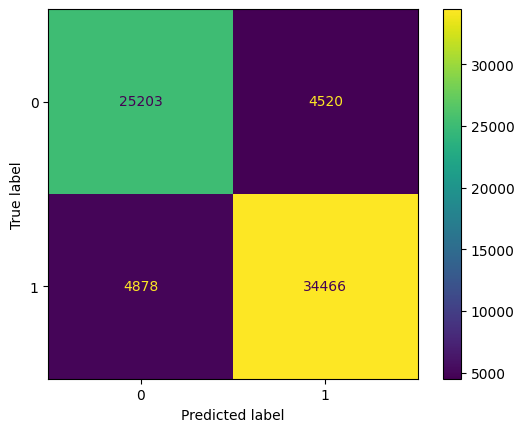

In [ ]:
from sklearn import metrics as m

confusion_matrix_bilstm = m.ConfusionMatrixDisplay.from_predictions(y_test, model_bilstm_preds)
confusion_matrix_bilstm

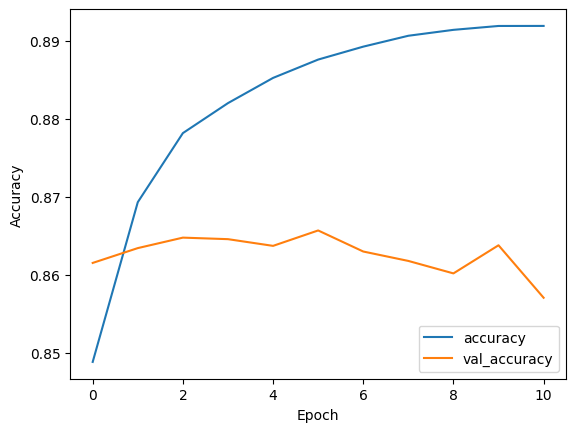

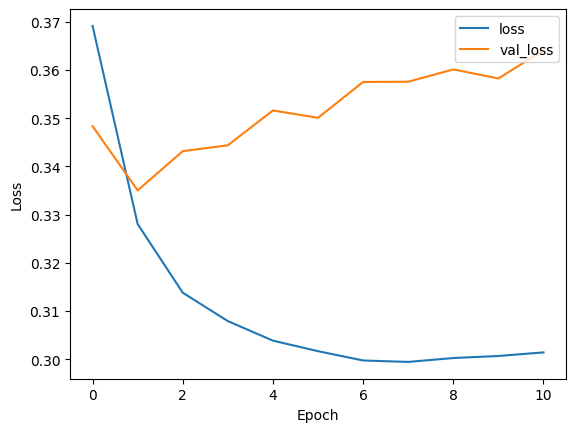

In [ ]:
import matplotlib.pyplot as plt

# Biểu đồ độ chính xác
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Biểu đồ hàm mất mát
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


# cmt code

In [ ]:
# dt_textvector = DecisionTreeClassifier(max_depth=50)
# dt_textvector.fit(x_train_vectors, y_train)
# bayes_textvector = MultinomialNB()
# bayes_textvector.fit(x_train_vectors, y_train)

In [ ]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # Tính các chỉ số đánh giá
# accuracy_bilstm = accuracy_score(y_test, model_bilstm_pred_probs)
# precision_bilstm = precision_score(y_test, model_bilstm_pred_probs, average='macro', zero_division=0)
# recall_bilstm = recall_score(y_test, model_bilstm_pred_probs, average='macro')
# f1_bilstm = f1_score(y_test, model_bilstm_pred_probs, average='macro')

# print("Accuracy:", accuracy_bilstm)
# print("Precision:", precision_bilstm)
# print("Recall:", recall_bilstm)
# print("F1 Score:", f1_bilstm)


Accuracy: 0.44054098879724984
Precision: 0.19407636281045862
Recall: 0.44054098879724984
F1 Score: 0.26944927540381713


In [ ]:
# # Define the model parameters
# # embedding_dim = 30  # Embedding dimension
# # dropout_threshold = 0.5  # Dropout rate for the LSTM layers
# # output_size = 256
# # activation_function = 'relu'  # Activation function for the LSTM layers
# # batch_size = 256  # Batch size
# # num_epochs = 100  # Number of training epochs
# # loss_function = 'binary_crossentropy'  # Loss function
# # learning_rate = 0.002  # Learning rate
# # optimizer_name = 'Adam'  # Optimizer name
# activation_function = 'relu'

# inputs = Input(shape=(1,), dtype=tf.string)
# text_vectors = text_vectorizer(inputs) # vectorize text inputs
# token_embeddings = token_embedding(text_vectors)

# x = Bidirectional(LSTM(256, return_sequences=True))(token_embeddings)
# x = GlobalAveragePooling1D()(x)
# x = Dense(units=500, activation=activation_function)(x)
# x = Dropout(0.5)(x)
# x = Dense(units=400, activation=activation_function)(x)
# x = Dropout(0.5)(x)
# x = Dense(units=300, activation=activation_function)(x)
# x = Dropout(0.5)(x)
# x = Dense(units=200, activation=activation_function)(x)
# x = Dropout(0.5)(x)
# x = Dense(units=100, activation=activation_function)(x)
# x = Dropout(0.5)(x)
# x = Dense(units=50, activation=activation_function)(x)
# outputs = Dense(len(set(df['target'])), activation="sigmoid")(x)
# model_bilstm = tf.keras.Model(inputs, outputs)


# model_bilstm.compile(loss="binary_crossentropy",
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=["accuracy"])

# model_bilstm.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 170)               0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 170, 170)          9791150   
 )                                                               
                                                                 
 bidirectional_2 (Bidirecti  (None, 170, 512)          874496    
 onal)                                                           
                                                                 
 global_average_pooling1d_2  (None, 512)               0         
  (GlobalAveragePooling1D)                                 

In [ ]:
# # trọng số câu/ độ dài tb các câu
# mean_len = np.mean(lens)
# mean_len

56.13686428539119

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
# from sklearn.feature_extraction.text import TfidfVectorizer


# # Tạo một pipeline với TfidfVectorizer và SVM classifier
# pipeline = Pipeline([
#     ("tf-idf", TfidfVectorizer()),
#     ("clf", SVC())
# ])

# # Tạo một tập hợp các tham số cần tối ưu hóa
# param_grid = {
#     'clf__kernel': ['linear', 'rbf', 'poly'],  # Các loại kernel của SVM
#     'clf__C': [0.1, 1, 10, 100],  # Tham số điều chuẩn C
# }

# # Khởi tạo GridSearchCV
# grid_search_svm = GridSearchCV(pipeline, param_grid, cv=5)


# Fit GridSearchCV với dữ liệu huấn luyện
# grid_search_svm.fit(x_train, y_train)

# # In ra thông số tốt nhất
# print("Best parameters found: ", grid_search_svm.best_params_)
# print("Best score: ", grid_search_svm.best_score_)

In [ ]:
# dt_textvector_predict = dt_textvector.predict(x_test_vectors)

# dt_textvector_results = calculate_results(y_true=y_temp,
#                                      y_pred=dt_textvector_predict)
# dt_textvector_results

{'accuracy': 0.6968362876787838,
 'precision': 0.6973471378267562,
 'recall': 0.6968362876787838,
 'f1': 0.6970695616955926}